In [2]:
import os
from ccdproc import CCDData
import matplotlib.pyplot as plt
import numpy as np
from astropy.modeling import models, fitting
from astropy import units as u
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle, match_coordinates_sky
from astroquery.gaia import Gaia
from astropy.stats import sigma_clipped_stats
from photutils import DAOStarFinder
from astropy.visualization import SqrtStretch, ZScaleInterval
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import CircularAperture
from goodman_pipeline.core import ra_dec_to_deg
from astropy.wcs.utils import fit_wcs_from_points
from stsci.stimage import xyxymatch

plt.style.use('dark_background')

for _file in sorted(os.listdir('./data/case_1')):
    print(_file)

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


Failed to import any qt binding


0347_SN2020uxz-23-10-2020_mask_out.fits
0348_SN2020uxz-23-10-2020_mask_in.fits
0349_SN2020uxz-23-10-2020_mask_out.fits
0350_SN2020uxz-23-10-2020_mask_out.fits
0351_SN2020uxz-23-10-2020_check.fits
default.param


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


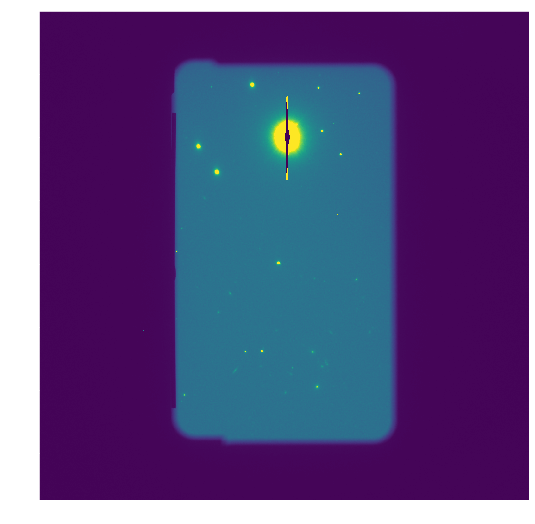

In [3]:
def show_fits(ccd, z1=None, z2=None):
    scale = ZScaleInterval()
    dz1, dz2 = scale.get_limits(ccd)
    if z1 is None:
        z1 = dz1
    else:
        z2 = float(z2)
    if z2 is None:
        z2 = dz2
    else:
        z2 = float(z2)
        
    fig, ax = plt.subplots(figsize=(16,9))
    ax.imshow(ccd.data, clim=(z1, z2))
    
mask_out_file = 'data/case_1/0347_SN2020uxz-23-10-2020_mask_out.fits'

ccd = CCDData.read(mask_out_file, unit='adu')
show_fits(ccd)


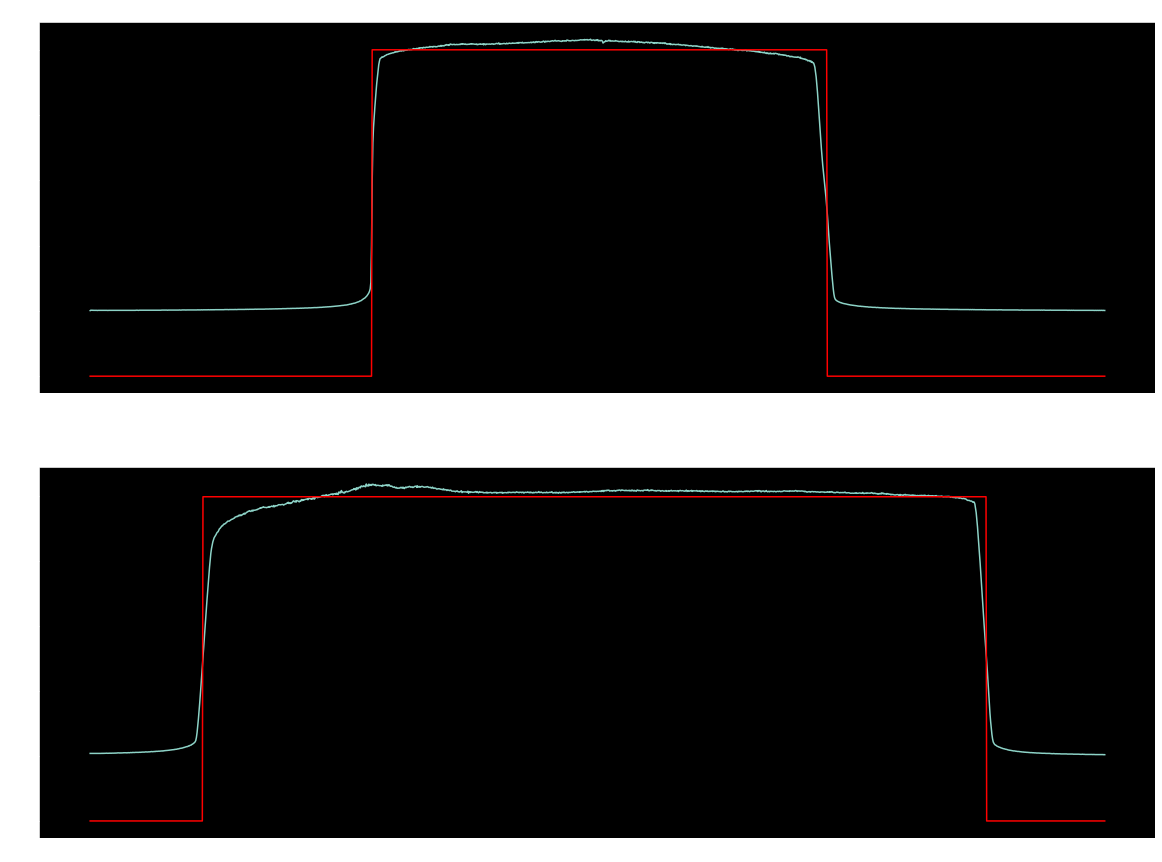

In [4]:

pixel_scale = Angle(0.15, u.arcsec) # arcseconds
x, y = ccd.data.shape
x_median = np.median(ccd.data[int(x/2. - 0.2 * x): int(x/2. + 0.2 * x),:], axis=0)
y_median = np.median(ccd.data[:, int(x/2. - 0.2 * x): int(x/2. + 0.2 * x)], axis=1)

# fit a box model
x_box_model = models.Box1D(amplitude=np.max(x_median), x_0=int(x/2.), width=int(x/2.))
y_box_model = models.Box1D(amplitude=np.max(y_median), x_0=int(y/2.), width=int(y/2.))

box_fitter = fitting.SimplexLSQFitter()

x_box_fitted = box_fitter(x_box_model, range(x), x_median)
y_box_fitted = box_fitter(y_box_model, range(y), y_median)

fig, (ax1, ax2) = plt.subplots(2, 1 ,figsize=(20,15))
ax1.set_title('X Axis')
ax1.plot(x_median)
ax1.plot(x_box_fitted(range(x)), color='r')
ax2.set_title('Y Axis')
ax2.plot(y_median)
ax2.plot(y_box_fitted(range(y)), color='r')
plt.show()

In [5]:
print(x_box_fitted)
print(y_box_fitted)

Model: Box1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             x_0              width      
    ------------------ ----------------- -----------------
    2498.1844376297518 776.5626703713348 694.0213651233265
Model: Box1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude            x_0              width       
    ----------------- ----------------- ------------------
    2491.073646659257 769.0209666261519 1194.7873259350988


In [6]:
serial_binning, parallel_binning =  [int(x) for x in ccd.header['CCDSUM'].split()]
print("Serial Binning: {} Paralell Binning: {}".format(serial_binning, parallel_binning))
x_width = x_box_fitted.width.value * (serial_binning * pixel_scale)
y_width = y_box_fitted.width.value * (parallel_binning * pixel_scale)

Serial Binning: 2 Paralell Binning: 2


1181.0498031078062 522.0 928.6269737561889


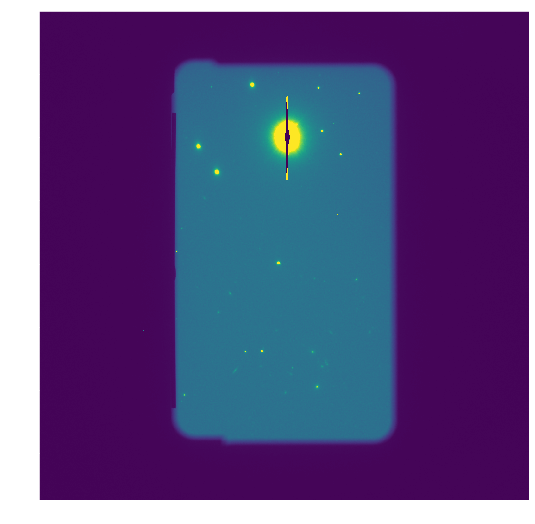

In [7]:
mean, median, std = sigma_clipped_stats(ccd.data, sigma=3.0)
print(mean, median, std)
show_fits(ccd)


In [8]:
daofind = DAOStarFinder(fwhm=3.0, threshold=5. * std)
sources = daofind(ccd.data - median)
for col in sources.colnames:
    sources[col].info.format = '%.8g'
print(sources)

 id xcentroid ycentroid sharpness  ... sky  peak    flux       mag    
--- --------- --------- ---------- ... --- ----- --------- -----------
  1 673.37452 233.47671 0.59755295 ...   0 51644 4.3888641  -1.6058803
  2 672.91855 235.85305 0.52474404 ...   0 53829 5.4411169  -1.8392201
  3 882.35879 244.75607 0.47182879 ...   0 21863  2.989302  -1.1889245
  4 1011.0826 262.45799 0.48499136 ...   0  9450 1.1192259 -0.12229435
  5 893.60525 381.72475 0.50046341 ...   0 28593 3.7617339  -1.4384702
  6 775.90413 385.57815 0.64315675 ...   0 54581 6.0209283  -1.9491586
  7 774.73047  391.3565 0.76327671 ...   0 54644 5.0494927  -1.7581194
  8 770.73145 402.21521 0.49039969 ...   0 52906 1.3841942 -0.35299256
  9 774.94028 408.45847 0.71723546 ...   0 54701 5.1921843  -1.7883753
 10  774.2404 410.66759  0.5005983 ...   0 53348 1.1402996  -0.1425474
 11 504.15977 430.06042 0.46871866 ...   0 55495 5.7813838  -1.9050795
 12 502.76692 430.91796  0.3566733 ...   0 53756  4.732344  -1.6876908
 13 95

[[ 673.37451513  233.47670735]
 [ 672.91854937  235.85305209]
 [ 882.35878971  244.75606769]
 [1011.08263231  262.45798953]
 [ 893.6052506   381.72475039]
 [ 775.90412905  385.57814678]
 [ 774.73047003  391.35649703]
 [ 770.73144909  402.21520982]
 [ 774.94028055  408.45846687]
 [ 774.24039682  410.66758979]
 [ 504.15976654  430.06041586]
 [ 502.76692155  430.91796187]
 [ 952.51472545  455.57988947]
 [ 563.06716236  511.00115833]
 [ 755.07441534  798.92731285]
 [ 703.8895272  1077.90784752]
 [ 651.58776315 1079.00506833]]


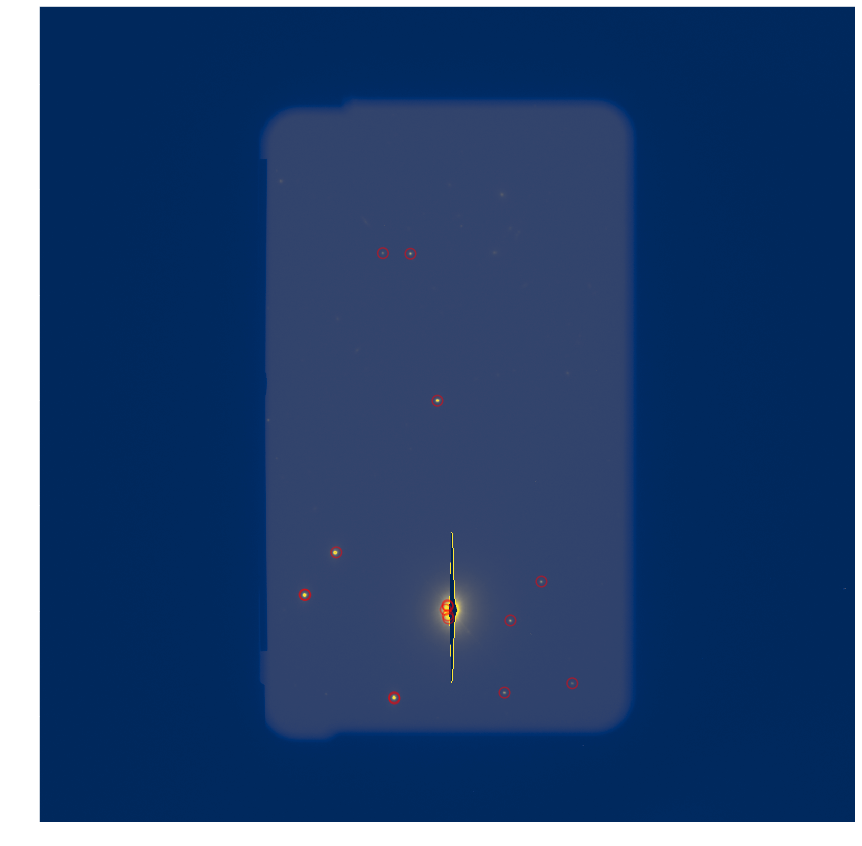

In [20]:
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
source_positions = (sources['xcentroid'], sources['ycentroid'])
print(positions)
apertures = CircularAperture(positions, r=10.)
norm = ImageNormalize(stretch=SqrtStretch())
fig, ax = plt.subplots(figsize=(20,15))
ax.imshow(ccd.data, cmap='cividis', origin='lower', norm=norm,
           interpolation='nearest')
apertures.plot(color='r', lw=1.5, alpha=0.5)

In [10]:
ra_deg, dec_deg = ra_dec_to_deg(right_ascension=ccd.header['RA'], declination=ccd.header['DEC'])

print(ra_deg, dec_deg)

21.073270833333336 12.9417075


## Convert pixel coordinates to RA DEC

In [11]:
def physical_to_sky(ccd, sources, pixel_scale_arcsec=0.15):
    x_length, y_length = ccd.data.shape
    x_center = x_length / 2.
    y_center = y_length / 2.
    x_binning, y_binning = [int(x) for x in ccd.header['CCDSUM'].split()]
    ra_deg, dec_deg = ra_dec_to_deg(right_ascension=ccd.header['RA'], declination=ccd.header['DEC'])
    pixel_scale = Angle(pixel_scale_arcsec, u.arcsec)
    sources_ra = []
    sources_dec = []
    for source in sources.iterrows('xcentroid', 'ycentroid'):
        source_ra = ra_deg * u.deg - (x_center - source[0]) * x_binning * pixel_scale
        sources_ra.append(source_ra)
        source_dec = dec_deg * u.deg - (y_center - source[1]) * y_binning * pixel_scale
        sources_dec.append(source_dec)
#         print(source[0], source[1], source_ra.deg, source_dec.deg)
        
    sources.add_columns(cols=[sources_ra, sources_dec], names=['ra', 'dec'])
    return sources
    
ccd_sky_coords = physical_to_sky(ccd=ccd, sources=sources)
print(ccd_sky_coords)

 id xcentroid ycentroid sharpness  ...     mag           ra            dec      
--- --------- --------- ---------- ... ----------- -------------- --------------
  1 673.37452 233.47671 0.59755295 ...  -1.6058803 21d03m53.5874s   12d53m47.99s
  2 672.91855 235.85305 0.52474404 ...  -1.8392201 21d03m53.4506s 12d53m48.7029s
  3 882.35879 244.75607 0.47182879 ...  -1.1889245 21d04m56.2826s 12d53m51.3738s
  4 1011.0826 262.45799 0.48499136 ... -0.12229435 21d05m34.8998s 12d53m56.6844s
  5 893.60525 381.72475 0.50046341 ...  -1.4384702 21d04m59.6566s 12d54m32.4644s
  6 775.90413 385.57815 0.64315675 ...  -1.9491586 21d04m24.3462s 12d54m33.6204s
  7 774.73047  391.3565 0.76327671 ...  -1.7581194 21d04m23.9941s 12d54m35.3539s
  8 770.73145 402.21521 0.49039969 ... -0.35299256 21d04m22.7944s 12d54m38.6116s
  9 774.94028 408.45847 0.71723546 ...  -1.7883753 21d04m24.0571s 12d54m40.4845s
 10  774.2404 410.66759  0.5005983 ...  -0.1425474 21d04m23.8471s 12d54m41.1473s
 11 504.15977 430.06042 0.46

In [12]:
scicoord = SkyCoord(ra=ra_deg, dec=dec_deg, unit=(u.degree, u.degree), frame='icrs')
width = u.Quantity(x_width.to_string(unit=u.degree, decimal=True), u.deg)
height = u.Quantity(y_width.to_string(unit=u.degree, decimal=True), u.deg)
print(width, height)
r = Gaia.query_object_async(coordinate=scicoord, width=width, height=height)
r.pprint()

0.0578351 deg 0.0995656 deg
INFO: Query finished. [astroquery.utils.tap.core]
        dist             solution_id     ... epoch_photometry_url
                                         ...                     
-------------------- ------------------- ... --------------------
0.005318437181255646 1635721458409799680 ...                     
0.021516756168978777 1635721458409799680 ...                     
 0.02364077457165017 1635721458409799680 ...                     
 0.02388984563181592 1635721458409799680 ...                     
0.032338882045061884 1635721458409799680 ...                     
 0.03278222522291485 1635721458409799680 ...                     
0.034708340512315694 1635721458409799680 ...                     
0.036822500666269686 1635721458409799680 ...                     
 0.04075863501110215 1635721458409799680 ...                     
  0.0418448015018869 1635721458409799680 ...                     
0.045756636565924096 1635721458409799680 ...                    

In [13]:

gaia_sources = SkyCoord(r['ra'], r['dec'])
# gaia_sources = np.transpose((r['ra'], r['dec']))
print(gaia_sources)
# print(dir(r))
# print(r.pprint_all)
# for _col in r.colnames:
#     print(_col)
# print(r.colnames)

<SkyCoord (ICRS): (ra, dec) in deg
    [(21.06855625, 12.93904261), (21.06452526, 12.96146132),
     (21.06023856, 12.96164241), (21.07250015, 12.96558567),
     (21.08452213, 12.91128235), (21.05233273, 12.91605815),
     (21.07003442, 12.90714386), (21.07960928, 12.90540603),
     (21.04748583, 12.90962536), (21.04444278, 12.97271252),
     (21.05982424, 12.98554576), (21.07852645, 12.89442847),
     (21.08918554, 12.8957193 ), (21.06133187, 12.89388342),
     (21.09691069, 12.98816726), (21.05071372, 12.89449727)]>


In [14]:
# print(np.array(sources['xcentroid'].data))
source_positions = (sources['xcentroid'].data, sources['ycentroid'].data)
print(source_positions)

# wcs = fit_wcs_from_points(xy=source_positions, world_coords=gaia_sources)

(array([ 673.37451513,  672.91854937,  882.35878971, 1011.08263231,
        893.6052506 ,  775.90412905,  774.73047003,  770.73144909,
        774.94028055,  774.24039682,  504.15976654,  502.76692155,
        952.51472545,  563.06716236,  755.07441534,  703.8895272 ,
        651.58776315]), array([ 233.47670735,  235.85305209,  244.75606769,  262.45798953,
        381.72475039,  385.57814678,  391.35649703,  402.21520982,
        408.45846687,  410.66758979,  430.06041586,  430.91796187,
        455.57988947,  511.00115833,  798.92731285, 1077.90784752,
       1079.00506833]))


[-0.0034639  -0.00342686 -0.0036791  -0.00374527  0.00125173 -0.00330931
 -0.00321398 -0.00288915 -0.00323102 -0.00317417  0.0015094   0.00162253
 -0.00353328 -0.00327535 -0.00305779  0.00494255  0.00141836]
[21.06488538 21.06484738 21.08230073 21.09302772 21.08323794 21.07342951
 21.07333171 21.07299845 21.07334919 21.07329087 21.05078415 21.05066808
 21.08814706 21.0556931  21.0716937  21.06742829 21.06306981]


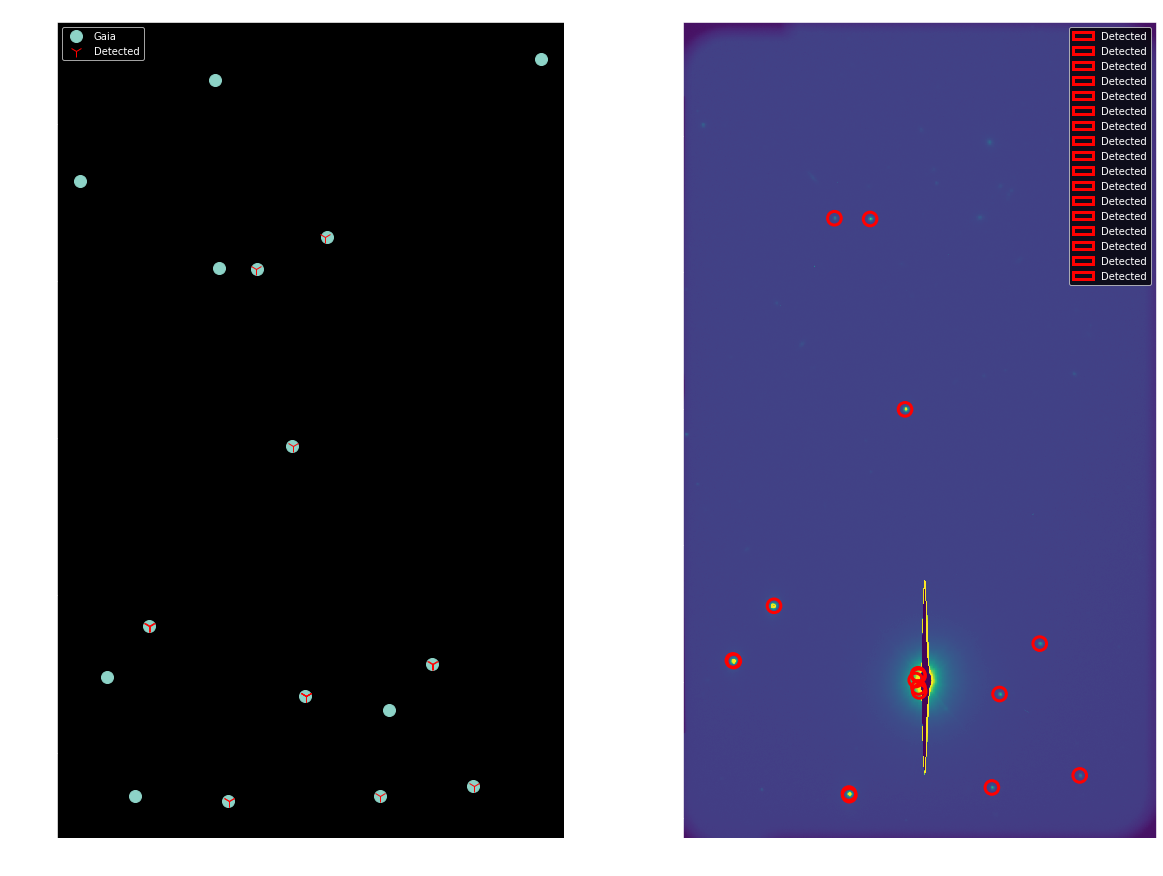

In [29]:

gaia_positions = np.transpose((r['ra'], r['dec']))

ccd_positions = np.transpose(ccd_sky_coords)
# print(ccd_sky_coords)
# print(ccd_sky_coords['ra'])

field = SkyCoord(ra=ccd_sky_coords['ra'] , dec=ccd_sky_coords['dec'])
gaia_catalog = SkyCoord(ra=gaia_sources.ra, dec=gaia_sources.dec)

# idx, d2d, d3d = field.match_to_catalog_sky(gaia_catalog)
idx, d2d, d3d = match_coordinates_sky(field, gaia_catalog)
# print(idx)
# print(d2d)
# print(d3d)
matches = gaia_catalog[idx]
# print(matches)
new_ra, new_dec = field.spherical_offsets_to(matches)
print(new_ra.deg)
print(field.ra.deg)
# print((matches.separation_3d(field) == d3d).all())
fix, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,15))
ax1.set_title('GAIA Sources')
ax1.set_xlabel('RA')
ax1.set_ylabel('DEC')
ax1.plot(gaia_sources.ra, gaia_sources.dec, 'o', markersize=12, label='Gaia')
ax1.plot(field.ra.deg + new_ra.deg , field.dec.deg + new_dec.deg, '1', color='red', markersize=12, label="Detected")
# ax1.plot(new_ra, new_dec, 'o', color='magenta', markersize=12)
# sub_data = [int(y_box_fitted.x_0.value - y_box_fitted.width.value / 2.):int(y_box_fitted.x_0.value + y_box_fitted.width.value / 2.),int(x_box_fitted.x_0.value - x_box_fitted.width.value / 2.):int(x_box_fitted.x_0.value + x_box_fitted.width.value / 2.)]
ax2.imshow(ccd.data, origin='lower', norm=norm,
           interpolation='nearest')
ax2.set_ylim(int(y_box_fitted.x_0.value - y_box_fitted.width.value / 2.), int(y_box_fitted.x_0.value + y_box_fitted.width.value / 2.))
ax2.set_xlim(int(x_box_fitted.x_0.value - x_box_fitted.width.value / 2.), int(x_box_fitted.x_0.value + x_box_fitted.width.value / 2.))
apertures.plot(color='red', lw=3, label='Detected')
ax1.legend(loc='best')
ax2.legend(loc='best')
# apertures = CircularAperture(gaia_positions, r=5.)
# apertures.plot(color='white', lw=1.5, alpha=0.5)

In [27]:
print(gaia_sources)

<SkyCoord (ICRS): (ra, dec) in deg
    [(21.06855625, 12.93904261), (21.06452526, 12.96146132),
     (21.06023856, 12.96164241), (21.07250015, 12.96558567),
     (21.08452213, 12.91128235), (21.05233273, 12.91605815),
     (21.07003442, 12.90714386), (21.07960928, 12.90540603),
     (21.04748583, 12.90962536), (21.04444278, 12.97271252),
     (21.05982424, 12.98554576), (21.07852645, 12.89442847),
     (21.08918554, 12.8957193 ), (21.06133187, 12.89388342),
     (21.09691069, 12.98816726), (21.05071372, 12.89449727)]>


In [ ]:
print(dir(apertures))
print(apertures.positions)